In [56]:
import sys
sys.path.append('~/transinet4lsst')
from lsst.daf.butler import Butler
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from mask_tools import should_ignore, get_enabled_flags_names
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

#### First obtain the truth list, the way we do as of now:

In [113]:
collection = sys.argv[1] if len(sys.argv)>1 else 'latest' #pick the latest collection in the butler registry by default

# Create a lsst butler object
butler = Butler('/repo/apv')

# The dimensions of the specific image we want to look at
visit = 982985
detector = 164


#--- Get the truth file URI (which is right next to the calexp file)
sciFile = butler.getURI('calexp',
                        collections='ap_verify-output',
                        dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector}).ospath
truthfile = sciFile + '.SNVAR.parq'
print(truthfile)

truth_all = pd.read_parquet(truthfile, engine='pyarrow')

truth_all

/repo/apv/ap_verify-output/20230307T235531Z/calexp/20251218/r/r_sim_1.4/982985/calexp_LSSTCam-imSim_r_r_sim_1_4_982985_R41_S02_ap_verify-output_20230307T235531Z.fits.SNVAR.parq


,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,flux_u_noMW,flux_g_noMW,flux_r_noMW,flux_i_noMW,flux_z_noMW,flux_y_noMW,tract,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry,obsHistID,MJD,bandpass,delta_flux
0,MS_9300_3652,4126946327,55.809744,-32.332801,0.945324,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4431,9,3,-1,-1,inf,-1,-1.000000,False,False,True,982985,61028.122882,r,7.922391
1,MS_9300_4184,4127142911,55.933019,-32.284723,0.973225,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4431,16,3,-1,-1,inf,-1,-1.000000,False,False,True,982985,61028.122882,r,17.903126
0,31411429981,-1,55.820381,-32.364658,0.000000,1,1,2.310072e+00,2.011389e+01,5.605774e+01,8.733038e+01,1.068484e+02,1.197150e+02,2.390107e+00,2.062942e+01,5.714767e+01,8.863153e+01,1.080729e+02,1.208527e+02,4431,9,2,-1,-1,27.028410,-1,-1.000000,False,False,True,982985,61028.122882,r,-0.417352
1,31107745011,-1,55.815901,-32.372821,0.000000,1,1,3.636094e+03,3.067184e+04,9.339306e+04,1.561495e+05,1.994355e+05,2.274639e+05,3.763048e+03,3.146307e+04,9.522001e+04,1.584920e+05,2.017389e+05,2.296427e+05,4431,9,2,-1,-1,18.974213,19488023263616405,0.005030,True,True,True,982985,61028.122882,r,-529.692749
2,31411429992,-1,55.808551,-32.365349,0.000000,1,1,1.360501e+01,1.065173e+02,2.913469e+02,4.534999e+02,5.554426e+02,6.201711e+02,1.408956e+01,1.093290e+02,2.971701e+02,4.604453e+02,5.619857e+02,6.262289e+02,4431,9,2,-1,-1,25.238974,19488023263584596,0.017922,True,True,True,982985,61028.122882,r,17.688076
3,31405687653,-1,55.769400,-32.385121,0.000000,1,1,3.210847e+02,1.358971e+03,2.467448e+03,3.095575e+03,3.397009e+03,3.610074e+03,3.327238e+02,1.395918e+03,2.517652e+03,3.143679e+03,3.437509e+03,3.645750e+03,4431,10,2,-1,-1,22.919380,19488160702569925,0.012625,True,True,True,982985,61028.122882,r,1.449948
4,31411430598,-1,55.784715,-32.371861,0.000000,1,1,1.526092e+04,3.580282e+04,4.894275e+04,5.485975e+04,5.661934e+04,5.711891e+04,1.581094e+04,3.678880e+04,4.993746e+04,5.571016e+04,5.729187e+04,5.768116e+04,4431,9,2,-1,-1,19.675779,19488023263616515,0.003004,True,True,True,982985,61028.122882,r,-72.041725
5,31411431584,-1,55.694891,-32.385083,0.000000,1,1,2.837938e+01,2.265870e+02,6.782509e+02,1.134425e+03,1.456302e+03,1.671033e+03,2.947191e+01,2.330310e+02,6.928635e+02,1.153159e+03,1.474815e+03,1.688649e+03,4431,10,2,-1,-1,24.321526,19488160702569673,0.054073,True,True,True,982985,61028.122882,r,0.474110
6,31405685097,-1,55.698054,-32.367778,0.000000,1,1,4.323857e+00,3.425957e+01,1.015408e+02,1.682722e+02,2.144816e+02,2.447493e+02,4.486736e+00,3.521356e+01,1.036824e+02,1.709927e+02,2.171506e+02,2.472750e+02,4431,10,2,-1,-1,26.383398,19488160702537820,0.065193,True,True,True,982985,61028.122882,r,-0.202717
7,31411429963,-1,55.709906,-32.370149,0.000000,1,1,1.610343e+03,1.000218e+04,2.158472e+04,2.929542e+04,3.327904e+04,3.600256e+04,1.670990e+03,1.028320e+04,2.204137e+04,2.976937e+04,3.369241e+04,3.637329e+04,4431,10,2,-1,-1,20.564634,19488160702570912,0.001382,True,True,True,982985,61028.122882,r,15.859311


In [163]:
#--- Obtain mask info for truth rows
sci = butler.get('calexp',
                 collections='ap_verify-output',
                 dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector})

X,Y = sci.getWcs().skyToPixelArray(ra=truth_all['ra'],dec=truth_all['dec'],degrees=True)
truth_all = truth_all.assign(x=X,y=Y) # add x,y columns to truth
mask = sci.getMaskedImage().getMask()
truth_all['mask'] = mask.getArray()[truth_all['y'].astype(int),truth_all['x'].astype(int)]
truth = truth_all[~truth_all.apply(lambda row: should_ignore(row['mask']), axis=1)]

truth

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,flux_u_noMW,flux_g_noMW,flux_r_noMW,flux_i_noMW,flux_z_noMW,flux_y_noMW,tract,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry,obsHistID,MJD,bandpass,delta_flux,x,y,mask
0,MS_9300_3652,4126946327,55.809744,-32.332801,0.945324,1,1,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4431,9,3,-1,-1,inf,-1,-1.000000,False,False,True,982985,61028.122882,r,7.922391,1836.168943,1786.292517,32
1,MS_9300_4184,4127142911,55.933019,-32.284723,0.973225,1,1,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4431,16,3,-1,-1,inf,-1,-1.000000,False,False,True,982985,61028.122882,r,17.903126,3608.015876,721.816330,32
0,31411429981,-1,55.820381,-32.364658,0.000000,1,1,2.310072,20.113888,56.057739,8.733038e+01,1.068484e+02,1.197150e+02,2.390107,20.629416,5.714767e+01,8.863153e+01,1.080729e+02,1.208527e+02,4431,9,2,-1,-1,27.028410,-1,-1.000000,False,False,True,982985,61028.122882,r,-0.417352,2059.019139,2339.377328,0
1,31107745011,-1,55.815901,-32.372821,0.000000,1,1,3636.093994,30671.835938,93393.062500,1.561495e+05,1.994355e+05,2.274639e+05,3763.048096,31463.066406,9.522001e+04,1.584920e+05,2.017389e+05,2.296427e+05,4431,9,2,-1,-1,18.974213,19488023263616405,0.005030,True,True,True,982985,61028.122882,r,-529.692749,2007.168215,2493.043168,32
2,31411429992,-1,55.808551,-32.365349,0.000000,1,1,13.605010,106.517334,291.346863,4.534999e+02,5.554426e+02,6.201711e+02,14.089564,109.329041,2.971701e+02,4.604453e+02,5.619857e+02,6.262289e+02,4431,9,2,-1,-1,25.238974,19488023263584596,0.017922,True,True,True,982985,61028.122882,r,17.688076,1881.492080,2371.355936,0
3,31405687653,-1,55.769400,-32.385121,0.000000,1,1,321.084656,1358.970947,2467.447998,3.095575e+03,3.397009e+03,3.610074e+03,332.723846,1395.917969,2.517652e+03,3.143679e+03,3.437509e+03,3.645750e+03,4431,10,2,-1,-1,22.919380,19488160702569925,0.012625,True,True,True,982985,61028.122882,r,1.449948,1328.094816,2790.628694,32
4,31411430598,-1,55.784715,-32.371861,0.000000,1,1,15260.922852,35802.816406,48942.753906,5.485975e+04,5.661934e+04,5.711891e+04,15810.935547,36788.800781,4.993746e+04,5.571016e+04,5.729187e+04,5.768116e+04,4431,9,2,-1,-1,19.675779,19488023263616515,0.003004,True,True,True,982985,61028.122882,r,-72.041725,1533.766505,2527.586751,32
5,31411431584,-1,55.694891,-32.385083,0.000000,1,1,28.379381,226.587006,678.250854,1.134425e+03,1.456302e+03,1.671033e+03,29.471909,233.031006,6.928635e+02,1.153159e+03,1.474815e+03,1.688649e+03,4431,10,2,-1,-1,24.321526,19488160702569673,0.054073,True,True,True,982985,61028.122882,r,0.474110,201.592933,2914.339264,32
6,31405685097,-1,55.698054,-32.367778,0.000000,1,1,4.323857,34.259571,101.540794,1.682722e+02,2.144816e+02,2.447493e+02,4.486736,35.213562,1.036824e+02,1.709927e+02,2.171506e+02,2.472750e+02,4431,10,2,-1,-1,26.383398,19488160702537820,0.065193,True,True,True,982985,61028.122882,r,-0.202717,215.423998,2599.018975,0
7,31411429963,-1,55.709906,-32.370149,0.000000,1,1,1610.342896,10002.177734,21584.724609,2.929542e+04,3.327904e+04,3.600256e+04,1670.990479,10283.201172,2.204137e+04,2.976937e+04,3.369241e+04,3.637329e+04,4431,10,2,-1,-1,20.564634,19488160702570912,0.001382,True,True,True,982985,61028.122882,r,15.859311,399.300981,2621.664320,32


#### Now Bruno's version

In [57]:
# Download the truth catalog
Brunos_SN = pd.read_csv('https://jira.lsstcorp.org/secure/attachment/70797/sn_truth_cat_DC2_visit_982985_det_164.csv')
Brunos_var = pd.read_csv('https://jira.lsstcorp.org/secure/attachment/70798/varstar_truth_cat_DC2_visit_982985_det_164.csv')

Brunos = pd.concat([Brunos_SN, Brunos_var])
Brunos

,id,host_galaxy,ra,dec,redshift,obshistid,mjd,bandpass,delta_flux,visit,detector,x_image,y_image,in_ccd,flux,transient_type,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,is_pointsource,is_variable
0,MS_9300_3652,4.126946e+09,55.809744,-32.332801,0.945324,982985,61028.122882,r,7.922390,982985,164,1843.514576,1777.764571,True,7.922390e+00,SNIa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MS_9300_4184,4.127143e+09,55.933019,-32.284723,0.973225,982985,61028.122882,r,17.903100,982985,164,3612.689623,710.427492,True,1.790310e+01,SNIa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,31411429981,NaN,55.820381,-32.364658,0.000000,982985,NaN,r,-0.417352,982985,164,2067.755518,2330.004105,True,5.564035e+01,VariableStar,2.310070e+00,2.011390e+01,5.605770e+01,8.733040e+01,1.068480e+02,1.197150e+02,1.0,1.0
1,31107745011,NaN,55.815901,-32.372821,0.000000,982985,NaN,r,-529.692743,982985,164,2016.305992,2483.649238,True,9.286341e+04,VariableStar,3.636090e+03,3.067180e+04,9.339310e+04,1.561490e+05,1.994350e+05,2.274640e+05,1.0,1.0
2,31411429992,NaN,55.808551,-32.365349,0.000000,982985,NaN,r,17.688076,982985,164,1890.330502,2362.300951,True,3.090351e+02,VariableStar,1.360500e+01,1.065170e+02,2.913470e+02,4.535000e+02,5.554430e+02,6.201710e+02,1.0,1.0
3,31405687653,NaN,55.769400,-32.385121,0.000000,982985,NaN,r,1.449948,982985,164,1338.102880,2782.289372,True,2.468900e+03,VariableStar,3.210850e+02,1.358970e+03,2.467450e+03,3.095570e+03,3.397010e+03,3.610070e+03,1.0,1.0
4,31411430598,NaN,55.784715,-32.371861,0.000000,982985,NaN,r,-72.041725,982985,164,1543.054872,2519.074789,True,4.887076e+04,VariableStar,1.526090e+04,3.580280e+04,4.894280e+04,5.485980e+04,5.661930e+04,5.711890e+04,1.0,1.0
5,31411431584,NaN,55.694891,-32.385083,0.000000,982985,NaN,r,0.474110,982985,164,212.155645,2908.004547,True,6.787251e+02,VariableStar,2.837940e+01,2.265870e+02,6.782510e+02,1.134430e+03,1.456300e+03,1.671030e+03,1.0,1.0
6,31405685097,NaN,55.698054,-32.367778,0.000000,982985,NaN,r,-0.202717,982985,164,225.141427,2592.935608,True,1.013383e+02,VariableStar,4.323860e+00,3.425960e+01,1.015410e+02,1.682720e+02,2.144820e+02,2.447490e+02,1.0,1.0
7,31411429963,NaN,55.709906,-32.370149,0.000000,982985,NaN,r,15.859311,982985,164,409.038575,2615.218523,True,2.160056e+04,VariableStar,1.610340e+03,1.000220e+04,2.158470e+04,2.929540e+04,3.327900e+04,3.600260e+04,1.0,1.0


#### Comparison plots (what we already have under DM-40191)

<IPython.core.display.Javascript object>


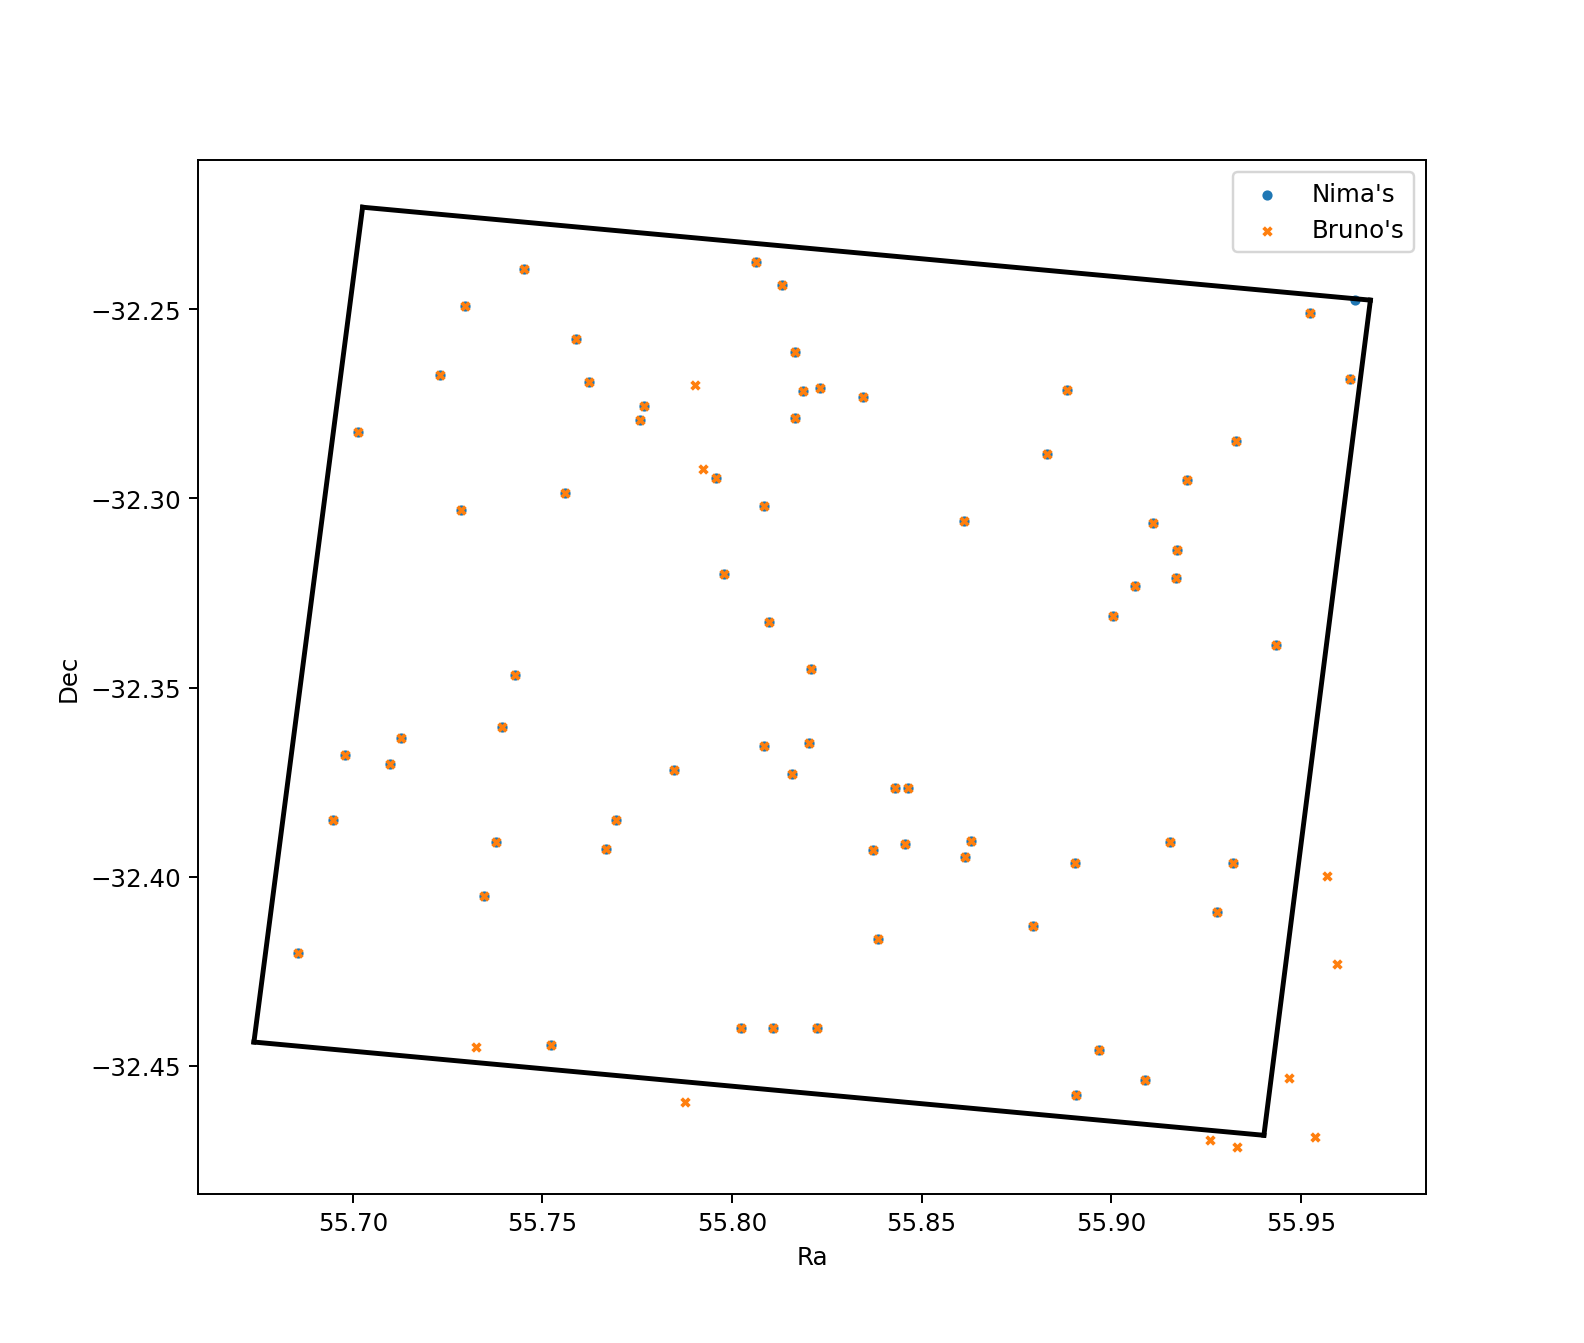

In [46]:
plt.figure()
plt.scatter(truth['ra'],truth['dec'],marker='o',s=10, label='Nima\'s')
plt.scatter(Brunos['ra'],Brunos['dec'],marker='x',s=10, label='Bruno\'s')
plt.xlabel('Ra')
plt.ylabel('Dec')
plt.legend()

#### Let's test the hypothesis that the bounding box is being interpreted differently

Below cell is mainly copied from Bruno's notebook (https://gist.github.com/BrunoSanchez/79a4ec1d8bb5b4736a7381ad6c730b4a)

In [160]:
def get_ra_dec_corners(wcs, box):
    c1 = wcs.pixelToSky(x=box.beginX, y=box.beginY)
    c2 = wcs.pixelToSky(x=box.beginX, y=box.endY)
    c3 = wcs.pixelToSky(x=box.endX, y=box.beginY)
    c4 = wcs.pixelToSky(x=box.endX, y=box.endY)
    ra1 = c1.getRa().asDegrees()
    dec1 = c1.getDec().asDegrees()
    ra2 = c2.getRa().asDegrees()
    dec2 = c2.getDec().asDegrees()
    ra3 = c3.getRa().asDegrees()
    dec3 = c3.getDec().asDegrees()
    ra4 = c4.getRa().asDegrees()
    dec4 = c4.getDec().asDegrees()
    return np.array([[ra1, ra2, ra3, ra4], [dec1, dec2, dec3, dec4]])

def get_maxmin_coords(coord):
    return np.min(coord), np.max(coord)

box = sci.getBBox()
ras, decs = get_ra_dec_corners(wcs, box)
ramin, ramax = get_maxmin_coords(ras)
decmin, decmax = get_maxmin_coords(decs)

And this is Nima's bounding box extraction method

In [159]:

# over-plot the calexp's bounding box.
sci = butler.get('calexp',
                 collections='ap_verify-output',
                 dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector})

# Convert the corners of the bounding boxes to sky coordinates.
from lsst.geom import SpherePoint, degrees, Box2D, Extent2D
from lsst import sphgeom
BBox = sci.getBBox()
wcs = sci.getWcs()
LocalBBox = Box2D(BBox)
BoxCorners = LocalBBox.getCorners()
SphCorners = [wcs.pixelToSky(corner).getVector() for corner in BoxCorners]
SkyRegion = sphgeom.ConvexPolygon(SphCorners)



<IPython.core.display.Javascript object>


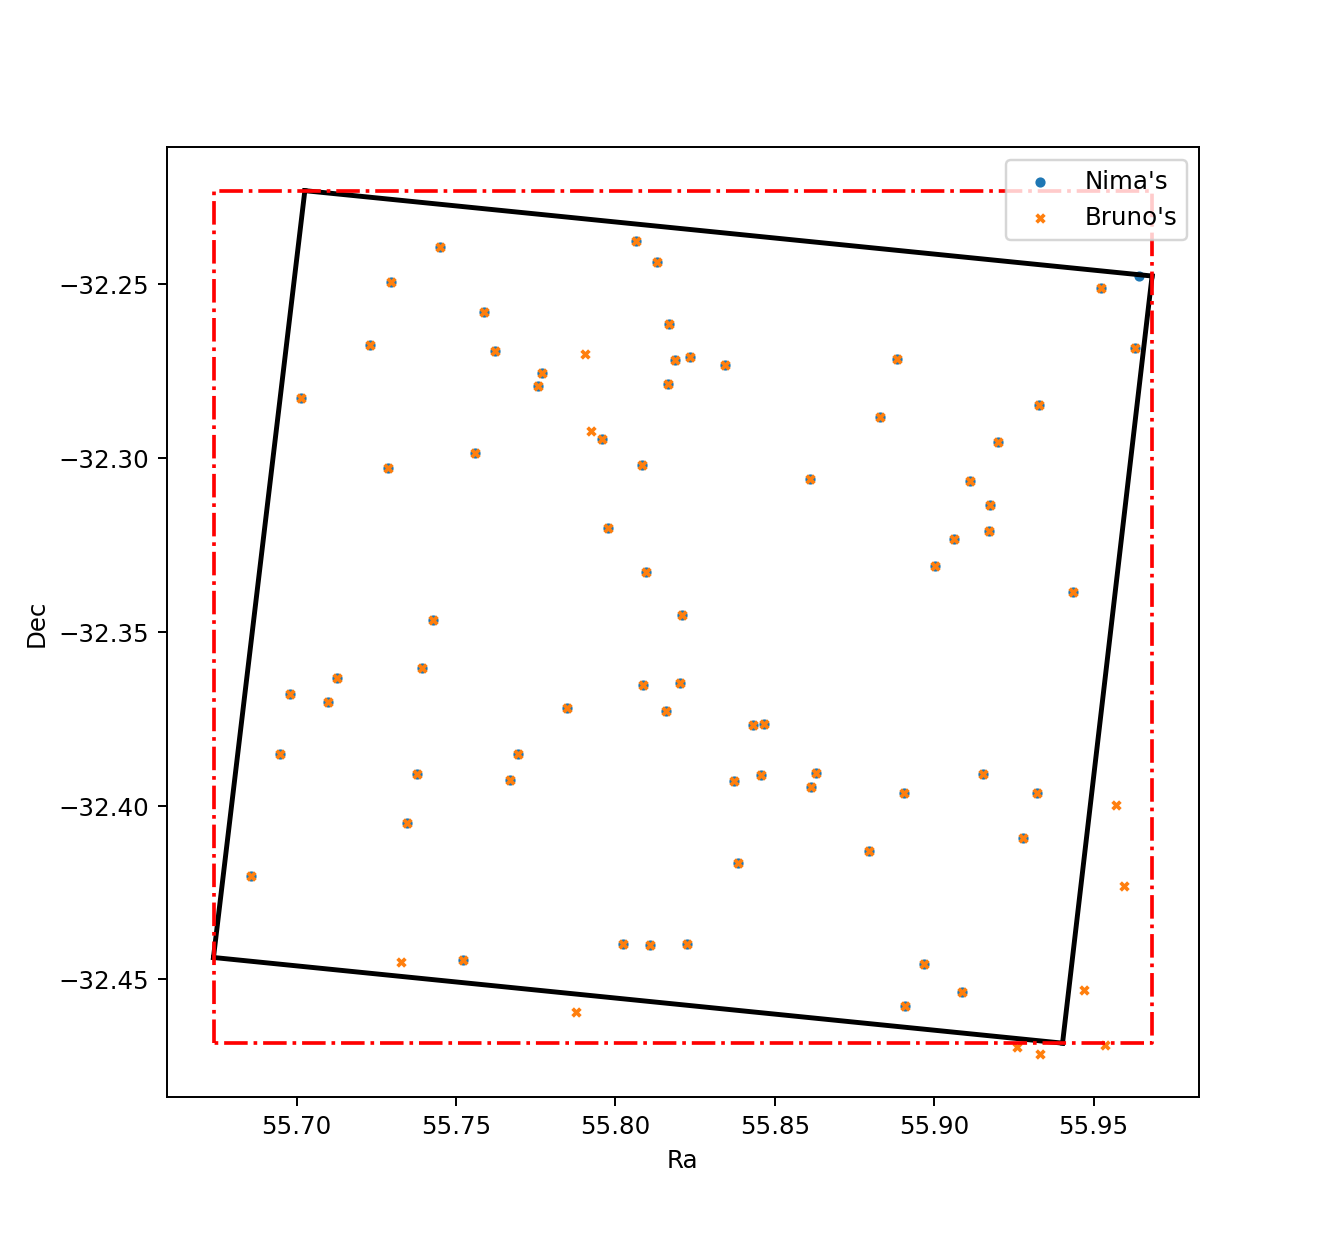

In [162]:
plt.figure()
plt.scatter(truth['ra'],truth['dec'],marker='o',s=10, label='Nima\'s')
plt.scatter(Brunos['ra'],Brunos['dec'],marker='x',s=10, label='Bruno\'s')
plt.xlabel('Ra')
plt.ylabel('Dec')


## plot the sky region by connecting the corners (Nima's method)
for i in range(4):
    plt.plot([SpherePoint(SphCorners[i]).getRa().asDegrees(), SpherePoint(SphCorners[(i+1)%4]).getRa().asDegrees()],
             [SpherePoint(SphCorners[i]).getDec().asDegrees(), SpherePoint(SphCorners[(i+1)%4]).getDec().asDegrees()],
                color='black',
                linewidth=2,
             )
    
## Bruno's box
plt.plot([ramin, ramin, ramax, ramax, ramin],[decmin, decmax, decmax, decmin, decmin],'-.r')

plt.legend()


So, the majority of those that are in Bruno's and not in Nima's are the ones that are contained by a straight-up bounding box. But the correct bounding box is tilted. So that explains a major part of the discrepencies.

#### But there are a few discrepancies which are not explained by the wrong bounding box issue. 
Let's take a look at them.

Some (undocumented) experiments showed that some coordinates, specifically those of the supernovae, in the two dataframes are off by values in the order of 1e-14. 
This could be potentially an important matter worth investigating in other cases. But here since we know the two tables come from the same source, and since we are only interested in finding correspondences, it is safe to ignore the precision issue.

In [80]:
# Round the floating point values in columns on which we want to run the matching.

truth.loc[:,'ra'] = truth['ra'].round(10)
truth.loc[:,'dec'] = truth['dec'].round(10)
Brunos.loc[:,'ra'] = Brunos['ra'].round(10)
Brunos.loc[:,'dec'] = Brunos['dec'].round(10)

In [136]:
# Let's also convert all ids to string
truth.loc[:,'id'] = truth['id'].astype(str)
Brunos.loc[:,'id'] = Brunos['id'].astype(str)

In [137]:
r = truth.merge(Brunos, on=['ra','dec'],how='outer', indicator=True)

mismatches = r[(r['_merge'] != 'both')]
mismatch_coords = sci.getWcs().skyToPixelArray(ra=mismatches['ra'],dec=mismatches['dec'],degrees=True)

INdices = LocalBBox.contains(mismatch_coords[0], mismatch_coords[1])
in_mismatches = mismatches[INdices]
in_mismatches


,id_x,host_galaxy_x,ra,dec,redshift_x,is_variable_x,is_pointsource_x,flux_u_x,flux_g_x,flux_r_x,flux_i_x,flux_z_x,flux_y_x,flux_u_noMW,flux_g_noMW,flux_r_noMW,flux_i_noMW,flux_z_noMW,flux_y_noMW,tract,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry,obsHistID,MJD,bandpass_x,delta_flux_x,x,y,mask,id_y,host_galaxy_y,redshift_y,obshistid,mjd,bandpass_y,delta_flux_y,visit,detector,x_image,y_image,in_ccd,flux,transient_type,flux_u_y,flux_g_y,flux_r_y,flux_i_y,flux_z_y,flux_y_y,is_pointsource_y,is_variable_y,_merge
52,31500330101,-1.0,55.964263,-32.247593,0.0,1.0,1.0,57.024666,467.464417,1437.125122,2450.700684,3185.864258,3683.08252,59.096527,480.001984,1466.343628,2488.901855,3224.105957,3719.749512,4431.0,16.0,2.0,-1.0,-1.0,23.506264,1.948803e+16,0.005336,True,True,True,982985.0,61028.122882,r,55.154003,4009.339917,5.601601,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
70,NaN,NaN,55.732586,-32.444870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30830343662,NaN,0.0,982985.0,NaN,r,-143.654370,982985.0,164.0,901.616919,3913.964822,True,2.033266e+06,VariableStar,218038.0,1098920.0,2033410.0,2547450.0,2770580.0,2931950.0,1.0,1.0,right_only
78,NaN,NaN,55.790356,-32.270034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30321355767,NaN,0.0,982985.0,NaN,r,-7207.912209,982985.0,164.0,1425.112941,687.183875,True,2.034032e+06,VariableStar,287183.0,1214020.0,2041240.0,2452630.0,2620000.0,2732900.0,1.0,1.0,right_only
79,NaN,NaN,55.792213,-32.292349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30830343259,NaN,0.0,982985.0,NaN,r,-1869.438283,982985.0,164.0,1497.736883,1083.393236,True,5.412531e+06,VariableStar,1102550.0,3529840.0,5414400.0,6344200.0,6723090.0,6918610.0,1.0,1.0,right_only


The first row exists only in Nima's, while the last three are only in Bruno's.
Let's start with the latter. Let's see how many of them have been in Nima's before filtering based on masks:

In [144]:
truth_all[truth_all.id.isin(in_mismatches.iloc[1:].id_y)]

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,flux_u_noMW,flux_g_noMW,flux_r_noMW,flux_i_noMW,flux_z_noMW,flux_y_noMW,tract,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry,obsHistID,MJD,bandpass,delta_flux,x,y,mask
12,30830343662,-1,55.732586,-32.444870,0.0,1,1,2.180379e+05,1098918.875,2033413.25,2547453.25,2770576.75,2931952.00,2.266201e+05,1131411.125,2078435.875,2590536.5,2806513.0,2963476.25,4431,10,2,-1,-1,15.629436,19488160702564816,0.000737,False,True,True,982985,61028.122882,r,-143.654373,888.493542,3922.530093,38
60,30321355767,-1,55.790356,-32.270034,0.0,1,1,2.871828e+05,1214024.125,2041236.25,2452630.25,2620003.75,2732898.75,2.977700e+05,1247870.875,2083679.875,2491568.0,2651890.0,2760472.00,4431,16,2,-1,-1,15.625267,19488027558572839,0.000794,False,True,True,982985,61028.122882,r,-7207.912109,1420.476664,694.186112,38
63,30830343259,-1,55.792213,-32.292349,0.0,1,1,1.102547e+06,3529843.500,5414399.00,6344195.00,6723090.00,6918612.00,1.143250e+06,3629018.750,5527253.500,6445109.5,6805055.5,6988529.50,4431,16,2,-1,-1,14.566125,19488027558570141,0.178786,False,True,True,982985,61028.122882,r,-1869.438232,1492.115946,1090.779960,38
64,30830343259,-1,55.792213,-32.292349,0.0,1,1,1.102547e+06,3529843.500,5414399.00,6344195.00,6723090.00,6918612.00,1.143250e+06,3629018.750,5527253.500,6445109.5,6805055.5,6988529.50,4431,16,2,-1,-1,14.566125,19488027558570142,0.261833,False,True,False,982985,61028.122882,r,-1869.438232,1492.115946,1090.779960,38
65,30830343259,-1,55.792213,-32.292349,0.0,1,1,1.102547e+06,3529843.500,5414399.00,6344195.00,6723090.00,6918612.00,1.143250e+06,3629018.750,5527253.500,6445109.5,6805055.5,6988529.50,4431,16,2,-1,-1,14.566125,19488027558570143,0.494081,False,True,False,982985,61028.122882,r,-1869.438232,1492.115946,1090.779960,38


Great! They all have been in the initial table, but are dropped for some reason. Let's find the reason:

In [145]:
truth_all[truth_all.id.isin(in_mismatches.iloc[1:].id_y)]['mask']

12    38
60    38
63    38
64    38
65    38
Name: mask, dtype: int32

In [147]:
sci.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NOT_DEBLENDED': 10,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 11}

### So they are all marked as SAT | INTRP -- hence dropped in Nima's by definition.

The only one that remains is the first object.